In [2]:
!pip install transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


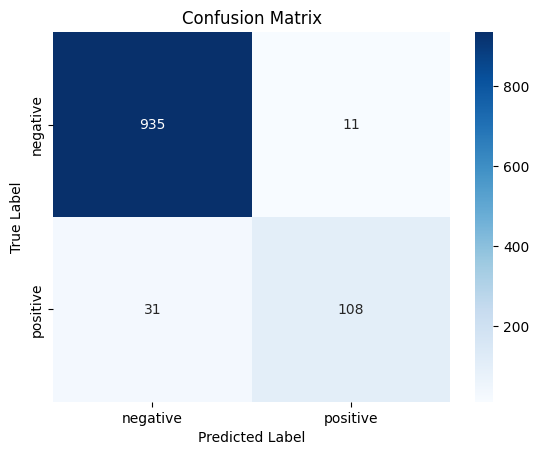

Accuracy: 0.96
Recall: 0.78
F1 Score: 0.84

Classification Report:
              precision    recall  f1-score   support

    negative       0.97      0.99      0.98       946
    positive       0.91      0.78      0.84       139

    accuracy                           0.96      1085
   macro avg       0.94      0.88      0.91      1085
weighted avg       0.96      0.96      0.96      1085



In [3]:
import os
from PIL import Image
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, classification_report
from transformers import AutoImageProcessor, AutoModelForImageClassification
import shutil

# Load the trained model and processor
model_path = "/content/drive/MyDrive/destination/directory/image_classification/fine-tuned-model"
processor_path = "/content/drive/MyDrive/destination/directory/image_classification/fine-tuned-processor"

# Load the model and processor
try:
    model = AutoModelForImageClassification.from_pretrained(model_path)
    processor = AutoImageProcessor.from_pretrained(processor_path)
except Exception as e:
    print(f"Error loading model or processor: {e}")
    raise

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Preprocess an image
def preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt")
        return inputs
    except Exception as e:
        print(f"Error preprocessing image {image_path}: {e}")
        return None

# Make predictions
def predict(image_path, model, processor):
    inputs = preprocess_image(image_path)
    if inputs is None:
        return None

    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

    return predictions.item()

# Paths to the datasets
negative_path = "/content/drive/MyDrive/extracted_files/extracted_images6/negative"
positive_path = "/content/drive/MyDrive/extracted_files/extracted_images6/positive"

# Directory for saving incorrect predictions
incorrect_predictions_dir = "/content/drive/MyDrive/extracted_files/incorrect_prediction"
false_negative_dir = os.path.join(incorrect_predictions_dir, "false_negative")
false_positive_dir = os.path.join(incorrect_predictions_dir, "false_positive")

# Create the folders for incorrect predictions if they don't exist
os.makedirs(false_negative_dir, exist_ok=True)
os.makedirs(false_positive_dir, exist_ok=True)

# List to store incorrect predictions
wrong_predictions = []

# Function to make predictions on the entire dataset and track incorrect ones
def predict_on_dataset(negative_path, positive_path, model, processor):
    labels = {'negative': 0, 'positive': 1}
    true_labels = []
    predicted_labels = []

    # Predict on negative images
    for filename in os.listdir(negative_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(negative_path, filename)
            prediction = predict(image_path, model, processor)

            if prediction is not None:
                true_labels.append(labels['negative'])
                predicted_labels.append(prediction)

                # Check if the prediction is incorrect (False Positive)
                if prediction != labels['negative']:
                    # Save the image in the false positive folder
                    shutil.copy(image_path, os.path.join(false_positive_dir, filename))

                    # Append the details of the wrong prediction
                    wrong_predictions.append({
                        "image_name": filename,
                        "model_prediction": "positive",
                        "actual_label": "negative"
                    })

    # Predict on positive images
    for filename in os.listdir(positive_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(positive_path, filename)
            prediction = predict(image_path, model, processor)

            if prediction is not None:
                true_labels.append(labels['positive'])
                predicted_labels.append(prediction)

                # Check if the prediction is incorrect (False Negative)
                if prediction != labels['positive']:
                    # Save the image in the false negative folder
                    shutil.copy(image_path, os.path.join(false_negative_dir, filename))

                    # Append the details of the wrong prediction
                    wrong_predictions.append({
                        "image_name": filename,
                        "model_prediction": "negative",
                        "actual_label": "positive"
                    })

    return true_labels, predicted_labels

# Predict on the dataset
true_labels, predicted_labels = predict_on_dataset(negative_path, positive_path, model, processor)

# Save wrong predictions to a CSV file
wrong_predictions_df = pd.DataFrame(wrong_predictions)
wrong_predictions_csv_path = "/content/drive/MyDrive/extracted_files/wrong_predictions.csv"
wrong_predictions_df.to_csv(wrong_predictions_csv_path, index=False)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

# Calculate accuracy, recall, and F1 score
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Display the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the accuracy, recall, and F1 score
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['negative', 'positive']))


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


ITERATION-1 (3 EPOCHS)

In [ ]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import Dataset, load_metric
import torch

# Function to load images and labels
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in ['negative', 'positive']:
        label_dir = os.path.join(folder, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            if os.path.isfile(img_path):
                images.append(img_path)
                labels.append(0 if label == 'negative' else 1)
    return images, labels

# Load dataset
dataset_dir = '/content/drive/MyDrive/extracted_files/Training_Data'
images, labels = load_images_from_folder(dataset_dir)

# Split into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create Hugging Face datasets
train_data = Dataset.from_dict({'image_path': train_images, 'label': train_labels})
test_data = Dataset.from_dict({'image_path': test_images, 'label': test_labels})

# Load the processor
processor = AutoImageProcessor.from_pretrained("rizvandwiki/gender-classification")

def preprocess(examples):
    images = [Image.open(img_path).convert("RGB") for img_path in examples["image_path"]]
    inputs = processor(images=images, return_tensors="pt")
    inputs['label'] = examples['label']
    return inputs

# Apply preprocessing
train_data = train_data.map(preprocess, batched=True)
test_data = test_data.map(preprocess, batched=True)

# Remove unused columns
train_data = train_data.remove_columns(["image_path"])
test_data = test_data.remove_columns(["image_path"])

# Set the format for PyTorch
train_data.set_format(type='torch', columns=['pixel_values', 'label'])
test_data.set_format(type='torch', columns=['pixel_values', 'label'])

# Load the model
model = AutoModelForImageClassification.from_pretrained("rizvandwiki/gender-classification")

# Define metrics
metric = load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=p.predictions.argmax(-1), references=p.label_ids)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained("/path/to/save/fine-tuned-model")
processor.save_pretrained("/path/to/save/fine-tuned-processor")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Map:   0%|          | 0/2742 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

<ipython-input-3-4eaaae32d586>:57: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.067600,0.065672,0.983965
2,0.005900,0.048542,0.989796
3,0.005800,0.041281,0.989796


['/path/to/save/fine-tuned-processor/preprocessor_config.json']

ITERTAION-2: WITHOUT SAMPLING

In [ ]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import Dataset, load_metric
import torch

# Function to load images and labels
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in ['negative', 'positive']:
        label_dir = os.path.join(folder, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            if os.path.isfile(img_path):
                try:
                    Image.open(img_path).verify()
                    images.append(img_path)
                    labels.append(0 if label == 'negative' else 1)
                except (IOError, SyntaxError) as e:
                    print(f"Invalid image {img_path}: {e}")
    return images, labels

# Load dataset from your directory
dataset_dir = '/content/drive/MyDrive/extracted_files/Training_Data'
images, labels = load_images_from_folder(dataset_dir)

# Split into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create Hugging Face datasets from your data
train_data = Dataset.from_dict({'image_path': train_images, 'label': train_labels})
test_data = Dataset.from_dict({'image_path': test_images, 'label': test_labels})

# Load the processor
processor = AutoImageProcessor.from_pretrained("rizvandwiki/gender-classification")

def preprocess(examples):
    images = [Image.open(img_path).convert("RGB") for img_path in examples["image_path"]]
    inputs = processor(images=images, return_tensors="pt")
    inputs['label'] = examples['label']
    return inputs

# Apply preprocessing
train_data = train_data.map(preprocess, batched=True)
test_data = test_data.map(preprocess, batched=True)

# Remove unused columns
train_data = train_data.remove_columns(["image_path"])
test_data = test_data.remove_columns(["image_path"])

# Set the format for PyTorch
train_data.set_format(type='torch', columns=['pixel_values', 'label'])
test_data.set_format(type='torch', columns=['pixel_values', 'label'])

# Load the model
model = AutoModelForImageClassification.from_pretrained("rizvandwiki/gender-classification")

# Define metrics
accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids

    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    precision = precision_metric.compute(predictions=preds, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=preds, references=labels, average='weighted')
    f1 = f1_metric.compute(predictions=preds, references=labels, average='weighted')

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=30,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
)

# Create a Trainer instance with your data
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,  # Your training dataset
    eval_dataset=test_data,  # Your evaluation dataset
    compute_metrics=compute_metrics,
)

# Train the model on your data
trainer.train()

# Save the model
model.save_pretrained("/content/drive/MyDrive/extracted_files/fine-tuned-model")
processor.save_pretrained("/content/drive/MyDrive/extracted_files/fine-tuned-processor")


ITERATITION-3(SAMPLING)

In [ ]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import Dataset, load_metric
import torch
import pandas as pd
from torchvision import transforms

# Function to load images and labels
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in ['negative', 'positive']:
        label_dir = os.path.join(folder, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            if os.path.isfile(img_path):
                try:
                    Image.open(img_path).verify()
                    images.append(img_path)
                    labels.append(0 if label == 'negative' else 1)
                except (IOError, SyntaxError) as e:
                    print(f"Invalid image {img_path}: {e}")
    return images, labels

# Load dataset
dataset_dir = '/content/drive/MyDrive/extracted_files (1)/Training_Data'
images, labels = load_images_from_folder(dataset_dir)

# Split into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Combine train data for resampling
df = pd.DataFrame({'image': train_images, 'label': train_labels})

# Separate majority and minority classes
df_majority = df[df.label == 0]
df_minority = df[df.label == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

# Combine back to form the new dataset
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Update images and labels
train_images = df_upsampled['image'].tolist()
train_labels = df_upsampled['label'].tolist()

# Create Hugging Face datasets
train_data = Dataset.from_dict({'image_path': train_images, 'label': train_labels})
test_data = Dataset.from_dict({'image_path': test_images, 'label': test_labels})

# Load the processor
processor = AutoImageProcessor.from_pretrained("rizvandwiki/gender-classification")

def preprocess(examples):
    images = [Image.open(img_path).convert("RGB") for img_path in examples["image_path"]]
    inputs = processor(images=images, return_tensors="pt")
    inputs['label'] = examples['label']
    return inputs

# Apply preprocessing
train_data = train_data.map(preprocess, batched=True)
test_data = test_data.map(preprocess, batched=True)

# Remove unused columns
train_data = train_data.remove_columns(["image_path"])
test_data = test_data.remove_columns(["image_path"])

# Set the format for PyTorch
train_data.set_format(type='torch', columns=['pixel_values', 'label'])
test_data.set_format(type='torch', columns=['pixel_values', 'label'])

# Load the model
model = AutoModelForImageClassification.from_pretrained("rizvandwiki/gender-classification", num_labels=2)

# Define class weights
class_weights = {0: 1.0, 1: 4.29}  # Weight for the minority class (positive)
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32))

def get_loss_fn():
    return loss_fn

model.config.problem_type = "single_label_classification"
model.config.num_labels = 2
model.config.id2label = {0: 'negative', 1: 'positive'}
model.config.label2id = {'negative': 0, 'positive': 1}

# Define metrics
accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids

    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    precision = precision_metric.compute(predictions=preds, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=preds, references=labels, average='weighted')
    f1 = f1_metric.compute(predictions=preds, references=labels, average='weighted')

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,  # Number of epochs
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the model and processor
model.save_pretrained("/content/drive/MyDrive/extracted_files (1)/Training_Data/fine-tuned-model2")
processor.save_pretrained("/content/drive/MyDrive/extracted_files (1)/Training_Data/fine-tuned-processor2")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Map:   0%|          | 0/4638 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

<ipython-input-3-9ea080b0114e>:93: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for precision contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/precision.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for recall contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/recall.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.058100,0.077100,0.981050,0.980978,0.981050,0.981010
2,0.003500,0.084508,0.983965,0.983906,0.983965,0.983931
3,0.001700,0.100709,0.982507,0.982392,0.982507,0.982433
4,0.000800,0.120789,0.982507,0.982392,0.982507,0.982433
5,0.000500,0.138284,0.979592,0.979374,0.979592,0.979416
6,0.000400,0.127307,0.979592,0.979557,0.979592,0.979135
7,0.000300,0.128458,0.978134,0.977961,0.978134,0.977697
8,0.000200,0.129989,0.979592,0.979423,0.979592,0.979231
9,0.000200,0.131303,0.981050,0.980889,0.981050,0.980758
10,0.000200,0.131920,0.981050,0.980889,0.981050,0.980758


['/content/drive/MyDrive/extracted_files (1)/Training_Data/fine-tuned-processor2/preprocessor_config.json']

CODE TO LOAD MODEL AND MAKE PREDICTION

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch

# Load the trained model and processor
model_path = "/content/drive/MyDrive/extracted_files/Training_Data/fine-tuned-model"
processor_path = "/content/drive/MyDrive/extracted_files/Training_Data/fine-tuned-processor"

model = AutoModelForImageClassification.from_pretrained(model_path)
processor = AutoImageProcessor.from_pretrained(processor_path)

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Preprocess an image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    return inputs

# Make predictions
def predict(image_path, model, processor):
    inputs = preprocess_image(image_path)

    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

    return predictions.item()

# test usage
image_path = "/content/drive/MyDrive/extracted_files/Training_Data/positive/2024-03-18 142839_15000245.png"
prediction = predict(image_path, model, processor)
labels = ['negative', 'positive']  # Define the labels
print(f"Predicted label: {labels[prediction]}")


Predicted label: positive


INFERENCE TIME

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch
import os
import time

# Load the trained model and processor
model_path = "/content/drive/MyDrive/extracted_files/Training_Data/fine-tuned-model"
processor_path = "/content/drive/MyDrive/extracted_files/Training_Data/fine-tuned-processor"

model = AutoModelForImageClassification.from_pretrained(model_path)
processor = AutoImageProcessor.from_pretrained(processor_path)

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Preprocess an image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    return inputs

# Make predictions
def predict(image_path, model, processor):
    inputs = preprocess_image(image_path)

    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

    return predictions.item()

# Function to make predictions on a batch of images
def predict_on_dataset(dataset_path, model, processor):
    labels = ['negative', 'positive']  # Define the labels
    results = []
    total_time = 0.0

    image_files = [f for f in os.listdir(dataset_path) if f.endswith(".jpg") or f.endswith(".png")]

    for filename in image_files:
        image_path = os.path.join(dataset_path, filename)
        start_time = time.time()
        prediction = predict(image_path, model, processor)
        end_time = time.time()
        elapsed_time = end_time - start_time
        total_time += elapsed_time
        results.append((filename, labels[prediction], elapsed_time))

    avg_time = total_time / len(image_files) if image_files else 0
    return results, total_time, avg_time

# Path to the dataset containing the 100 images
dataset_path = "/content/drive/MyDrive/ANSYS/viT_Infernce"

# Make predictions on the dataset
results, total_time, avg_time = predict_on_dataset(dataset_path, model, processor)

# Print the results
for filename, label, time_taken in results:
    print(f"{filename}: {label} (Time taken: {time_taken:.4f} seconds)")

# Print total and average time
print(f"Total time taken: {total_time:.4f} seconds")
print(f"Average time per image: {avg_time:.4f} seconds")


In [ ]:
import zipfile

# Path to your zip file
zip_file_path = '/content/drive/MyDrive/extracted_files/testing.zip'

# Destination directory to unzip files
destination_dir = '/content/drive/MyDrive/extracted_files'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print("Unzipping completed!")


Unzipping completed!


In [ ]:
# Install the required libraries
!pip install rarfile
!apt-get install unrar

from google.colab import drive
import rarfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the rar file
rar_file_path = '/content/drive/MyDrive/Unmarked_Data.rar'

# Define the directory where you want to extract the contents
extract_to = '/content/drive/MyDrive/extracted_files_vision/'

# Create the directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract the contents of the rar file
with rarfile.RarFile(rar_file_path, 'r') as rar_ref:
    rar_ref.extractall(extract_to)

print('Unzipping complete!')


In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch
import os
import pandas as pd  # For handling CSV files

# Ensure necessary packages are installed
!pip install transformers torch pillow pandas

# Load the trained model and processor
model_path = "/content/drive/MyDrive/destination/directory/image_classification/fine-tuned-model"
processor_path = "/content/drive/MyDrive/destination/directory/image_classification/fine-tuned-processor"

# Load the model and processor
try:
    model = AutoModelForImageClassification.from_pretrained(model_path)
    processor = AutoImageProcessor.from_pretrained(processor_path)
except Exception as e:
    print(f"Error loading model or processor: {e}")
    raise

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Preprocess an image
def preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt")
        return inputs
    except Exception as e:
        print(f"Error preprocessing image {image_path}: {e}")
        return None

# Make predictions
def predict(image_path, model, processor):
    inputs = preprocess_image(image_path)
    if inputs is None:
        return None

    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

    return predictions.item()

# Function to make predictions on a batch of images and save results to CSV
def predict_on_dataset(dataset_path, model, processor, csv_file_path):
    labels = ['negative', 'positive']  # Define the labels
    results = []

    image_files = [f for f in os.listdir(dataset_path) if f.endswith(".jpg") or f.endswith(".png")]

    for filename in image_files:
        image_path = os.path.join(dataset_path, filename)
        prediction = predict(image_path, model, processor)

        if prediction is not None:
            results.append({
                "filename": filename,
                "label": labels[prediction]
            })
        else:
            results.append({
                "filename": filename,
                "label": "error"
            })

    # Create a DataFrame from the results
    df = pd.DataFrame(results)

    # Save the DataFrame to a CSV file
    df.to_csv(csv_file_path, index=False)

    return df

# Path to the dataset containing the images
dataset_path = "/content/drive/MyDrive/extracted_files/testing"


# Make predictions on the dataset and show confusion matrix




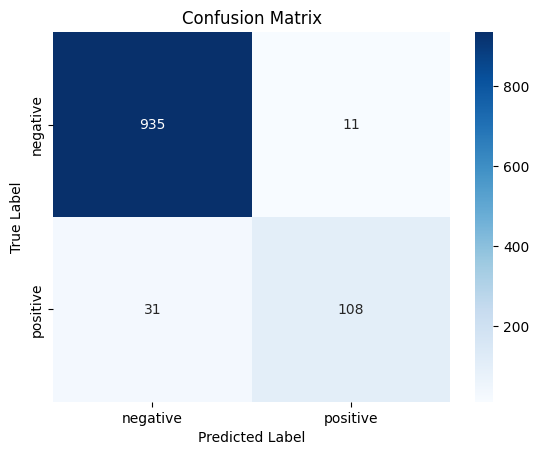

Accuracy: 0.96
Recall: 0.78
F1 Score: 0.84

Classification Report:
              precision    recall  f1-score   support

    negative       0.97      0.99      0.98       946
    positive       0.91      0.78      0.84       139

    accuracy                           0.96      1085
   macro avg       0.94      0.88      0.91      1085
weighted avg       0.96      0.96      0.96      1085



In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure necessary packages are installed
!pip install transformers torch pillow pandas scikit-learn seaborn

# Load the trained model and processor
model_path = "/content/drive/MyDrive/destination/directory/image_classification/fine-tuned-model"
processor_path = "/content/drive/MyDrive/destination/directory/image_classification/fine-tuned-processor"

# Load the model and processor
try:
    model = AutoModelForImageClassification.from_pretrained(model_path)
    processor = AutoImageProcessor.from_pretrained(processor_path)
except Exception as e:
    print(f"Error loading model or processor: {e}")
    raise

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Preprocess an image
def preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt")
        return inputs
    except Exception as e:
        print(f"Error preprocessing image {image_path}: {e}")
        return None

# Make predictions
def predict(image_path, model, processor):
    inputs = preprocess_image(image_path)
    if inputs is None:
        return None

    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

    return predictions.item()

# Paths to the datasets
negative_path = "/content/drive/MyDrive/extracted_files/extracted_images6/negative"
positive_path = "/content/drive/MyDrive/extracted_files/extracted_images6/positive"

# Function to make predictions on the entire dataset
def predict_on_dataset(negative_path, positive_path, model, processor):
    labels = {'negative': 0, 'positive': 1}
    true_labels = []
    predicted_labels = []

    # Predict on negative images
    for filename in os.listdir(negative_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(negative_path, filename)
            prediction = predict(image_path, model, processor)

            if prediction is not None:
                true_labels.append(labels['negative'])
                predicted_labels.append(prediction)

    # Predict on positive images
    for filename in os.listdir(positive_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(positive_path, filename)
            prediction = predict(image_path, model, processor)

            if prediction is not None:
                true_labels.append(labels['positive'])
                predicted_labels.append(prediction)

    return true_labels, predicted_labels

# Predict on the dataset
true_labels, predicted_labels = predict_on_dataset(negative_path, positive_path, model, processor)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

# Calculate accuracy, recall, and F1 score
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Display the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the accuracy, recall, and F1 score
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['negative', 'positive']))


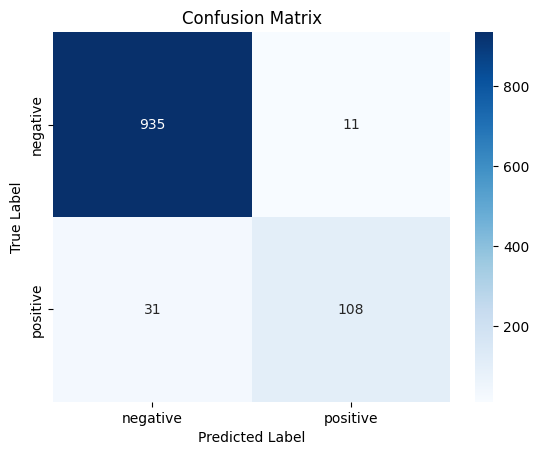

Accuracy: 0.96
Recall: 0.78
F1 Score: 0.84

Classification Report:
              precision    recall  f1-score   support

    negative       0.97      0.99      0.98       946
    positive       0.91      0.78      0.84       139

    accuracy                           0.96      1085
   macro avg       0.94      0.88      0.91      1085
weighted avg       0.96      0.96      0.96      1085



In [ ]:
import os
from PIL import Image
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, classification_report
from transformers import AutoImageProcessor, AutoModelForImageClassification
import shutil

# Load the trained model and processor
model_path = "/content/drive/MyDrive/destination/directory/image_classification/fine-tuned-model"
processor_path = "/content/drive/MyDrive/destination/directory/image_classification/fine-tuned-processor"

# Load the model and processor
try:
    model = AutoModelForImageClassification.from_pretrained(model_path)
    processor = AutoImageProcessor.from_pretrained(processor_path)
except Exception as e:
    print(f"Error loading model or processor: {e}")
    raise

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Preprocess an image
def preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt")
        return inputs
    except Exception as e:
        print(f"Error preprocessing image {image_path}: {e}")
        return None

# Make predictions
def predict(image_path, model, processor):
    inputs = preprocess_image(image_path)
    if inputs is None:
        return None

    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

    return predictions.item()

# Paths to the datasets
negative_path = "/content/drive/MyDrive/extracted_files/extracted_images6/negative"
positive_path = "/content/drive/MyDrive/extracted_files/extracted_images6/positive"

# Directory for saving incorrect predictions
incorrect_predictions_dir = "/content/drive/MyDrive/extracted_files/incorrect_predictions"

# Create the folder for incorrect predictions if it doesn't exist
if not os.path.exists(incorrect_predictions_dir):
    os.makedirs(incorrect_predictions_dir)

# List to store incorrect predictions
wrong_predictions = []

# Function to make predictions on the entire dataset and track incorrect ones
def predict_on_dataset(negative_path, positive_path, model, processor):
    labels = {'negative': 0, 'positive': 1}
    true_labels = []
    predicted_labels = []

    # Predict on negative images
    for filename in os.listdir(negative_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(negative_path, filename)
            prediction = predict(image_path, model, processor)

            if prediction is not None:
                true_labels.append(labels['negative'])
                predicted_labels.append(prediction)

                # Check if the prediction is incorrect
                if prediction != labels['negative']:
                    # Save the image in the incorrect predictions folder
                    shutil.copy(image_path, os.path.join(incorrect_predictions_dir, filename))

                    # Append the details of the wrong prediction
                    wrong_predictions.append({
                        "image_name": filename,
                        "model_prediction": "positive" if prediction == 1 else "negative",
                        "actual_label": "negative"
                    })

    # Predict on positive images
    for filename in os.listdir(positive_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(positive_path, filename)
            prediction = predict(image_path, model, processor)

            if prediction is not None:
                true_labels.append(labels['positive'])
                predicted_labels.append(prediction)

                # Check if the prediction is incorrect
                if prediction != labels['positive']:
                    # Save the image in the incorrect predictions folder
                    shutil.copy(image_path, os.path.join(incorrect_predictions_dir, filename))

                    # Append the details of the wrong prediction
                    wrong_predictions.append({
                        "image_name": filename,
                        "model_prediction": "negative" if prediction == 0 else "positive",
                        "actual_label": "positive"
                    })

    return true_labels, predicted_labels

# Predict on the dataset
true_labels, predicted_labels = predict_on_dataset(negative_path, positive_path, model, processor)

# Save wrong predictions to a CSV file
wrong_predictions_df = pd.DataFrame(wrong_predictions)
wrong_predictions_csv_path = "/content/drive/MyDrive/extracted_files/wrong_predictions.csv"
wrong_predictions_df.to_csv(wrong_predictions_csv_path, index=False)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

# Calculate accuracy, recall, and F1 score
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Display the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the accuracy, recall, and F1 score
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['negative', 'positive']))


In [ ]:
import os
import pandas as pd
import shutil

# Path to the base folder containing the images
base_image_folder_path = "/content/drive/MyDrive/extracted_files/Training_Data"

# Path to the Excel file containing the barcodes
excel_file_path = "/content/drive/MyDrive/destination/Unmarked Data.xlsx"

# Path to the destination folder where images will be saved
destination_folder_path = "/content/drive/MyDrive/extracted_files/extracted_images_testing"

# Create the destination subfolder if it doesn't exist
if not os.path.exists(destination_folder_path):
    os.makedirs(destination_folder_path)

# Function to process a sheet and save images
# Function to process a sheet and save images
def process_images(sheet_name, image_subfolder, destination_subfolder, barcode_col_index):
    # Read the specific sheet from the Excel file, skipping the first two rows
    df_barcodes = pd.read_excel(excel_file_path, sheet_name=sheet_name, skiprows=2)

    # Use the correct column by index
    barcode_list = df_barcodes.iloc[:, barcode_col_index].astype(str).tolist()

    # Full path to the image subfolder (negative/positive)
    image_folder_path = os.path.join(base_image_folder_path, image_subfolder)

    # Full path to the destination subfolder (negative/positive)
    destination_subfolder_path = os.path.join(destination_folder_path, destination_subfolder)

    # Create the destination subfolder if it doesn't exist
    if not os.path.exists(destination_subfolder_path):
        os.makedirs(destination_subfolder_path)

    # Iterate over the images in the folder
    for filename in os.listdir(image_folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Add other extensions if necessary
            # Extract the last 8 digits of the filename (the barcode)
            barcode = filename[-12:-4]  # Extract the last 8 digits before the file extension

            # Check if the extracted barcode is in the list
            if barcode in barcode_list:
                # If the barcode matches, copy the image to the new folder
                source_path = os.path.join(image_folder_path, filename)
                destination_path = os.path.join(destination_subfolder_path, filename)
                shutil.copy(source_path, destination_path)

# Process the negative images
process_images(sheet_name="Negative", image_subfolder="negative", destination_subfolder="negative", barcode_col_index=2)

# Process the positive images
process_images(sheet_name="Positive", image_subfolder="positive", destination_subfolder="positive", barcode_col_index=1)

print("Image extraction completed.")



Image extraction completed.


In [ ]:
import os
import pandas as pd
import shutil

# Path to the Excel file containing the barcodes
excel_file_path = "/content/drive/MyDrive/destination/Unmarked Data.xlsx"

# Path to the destination folder where images will be saved
destination_folder_path = "/content/drive/MyDrive/extracted_files/extracted_images2"

# Path to the folder containing the image-only dataset
image_only_folder_path = "/content/drive/MyDrive/extracted_files/All_Data"

# Create the destination subfolder if it doesn't exist
if not os.path.exists(destination_folder_path):
    os.makedirs(destination_folder_path)

# Function to process a sheet and extract matching images from the image-only dataset
def extract_images_from_image_only_dataset(sheet_name, destination_subfolder, barcode_col_index):
    # Read the specific sheet from the Excel file, skipping the first two rows
    df_barcodes = pd.read_excel(excel_file_path, sheet_name=sheet_name, skiprows=2)

    # Use the correct column by index to get the list of barcodes
    barcode_list = df_barcodes.iloc[:, barcode_col_index].astype(str).tolist()

    # Full path to the destination subfolder (negative/positive)
    destination_subfolder_path = os.path.join(destination_folder_path, destination_subfolder)

    # Create the destination subfolder if it doesn't exist
    if not os.path.exists(destination_subfolder_path):
        os.makedirs(destination_subfolder_path)

    # Iterate over the images in the image-only folder
    for filename in os.listdir(image_only_folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Add other extensions if necessary
            # Extract the last 8 digits of the filename (the barcode)
            barcode = filename[-12:-4]  # Extract the last 8 digits before the file extension

            # Check if the extracted barcode is in the list
            if barcode in barcode_list:
                # If the barcode matches, copy the image to the corresponding folder (positive/negative)
                source_path = os.path.join(image_only_folder_path, filename)
                destination_path = os.path.join(destination_subfolder_path, filename)
                shutil.copy(source_path, destination_path)

# Extract images from the Positive sheet and save to the Positive folder from the image-only dataset
extract_images_from_image_only_dataset(sheet_name="Sheet1", destination_subfolder="positive", barcode_col_index=1)

# Extract images from the Negative sheet and save to the Negative folder from the image-only dataset
extract_images_from_image_only_dataset(sheet_name="Sheet1", destination_subfolder="negative", barcode_col_index=2)

print("Image extraction from image-only dataset completed.")


Image extraction from image-only dataset completed.


In [ ]:
import os
import pandas as pd
import shutil

# Path to the Excel file containing the barcodes
excel_file_path = "/content/drive/MyDrive/destination/Unmarked Data.xlsx"

# Path to the destination folder where images will be saved
destination_folder_path = "/content/drive/MyDrive/extracted_files/extracted_images4"

# Path to the folder containing the image-only dataset
image_only_folder_path = "/content/drive/MyDrive/extracted_files/All_Data"

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder_path):
    os.makedirs(destination_folder_path)

# Function to process the Excel sheet and extract matching images
def extract_images_from_image_only_dataset(sheet_name, barcode_col_index):
    # Read the specific sheet from the Excel file, skipping the first two rows
    df_barcodes = pd.read_excel(excel_file_path, sheet_name=sheet_name, skiprows=1)

    # Strip any whitespace from column names
    df_barcodes.columns = df_barcodes.columns.str.strip()

    # Iterate over the DataFrame rows
    for _, row in df_barcodes.iterrows():
        barcode = str(int(row['Barcode No']))  # Convert Barcode No to string
        result = row['Result'].strip().upper()  # Clean up and standardize the Result string

        # Determine destination subfolder based on the result
        if result == "POSITIVE":
            destination_subfolder = "positive"
        elif result == "NEGATIVE":
            destination_subfolder = "negative"
        else:
            continue  # Skip rows with invalid results

        # Full path to the destination subfolder
        destination_subfolder_path = os.path.join(destination_folder_path, destination_subfolder)

        # Create the destination subfolder if it doesn't exist
        if not os.path.exists(destination_subfolder_path):
            os.makedirs(destination_subfolder_path)

        # Iterate over the images in the image-only folder
        for filename in os.listdir(image_only_folder_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):  # Add other extensions if necessary
                # Extract the barcode part from the filename
                image_barcode = filename[-12:-4]  # Extract the last 8 digits before the file extension

                # Check if the extracted barcode matches the barcode from the Excel sheet
                if image_barcode == barcode:
                    # Copy the image to the appropriate folder
                    source_path = os.path.join(image_only_folder_path, filename)
                    destination_path = os.path.join(destination_subfolder_path, filename)
                    shutil.copy(source_path, destination_path)
                    break  # Break after finding the first match

# Extract images and save to the corresponding folders
extract_images_from_image_only_dataset(sheet_name="Sheet1", barcode_col_index=1)

print("Image extraction from image-only dataset completed.")


Image extraction from image-only dataset completed.


In [ ]:
import os
import pandas as pd
import shutil

# Path to the Excel file containing the barcodes
excel_file_path = "/content/drive/MyDrive/destination/Unmarked Data.xlsx"

# Path to the destination folder where images will be saved
destination_folder_path = "/content/drive/MyDrive/extracted_files/extracted_images5"

# Path to the folder containing the image-only dataset
image_only_folder_path = "/content/drive/MyDrive/extracted_files/All_Data"

# Path to save the missing images list
missing_images_excel_path = "/content/drive/MyDrive/extracted_files/missing_images.xlsx"

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder_path):
    os.makedirs(destination_folder_path)

# Initialize a list to track missing images
missing_images = []

# Function to process the Excel sheet and extract matching images
def extract_images_from_image_only_dataset(sheet_name, barcode_col_index):
    # Read the specific sheet from the Excel file, skipping the first two rows
    df_barcodes = pd.read_excel(excel_file_path, sheet_name=sheet_name, skiprows=1)

    # Strip any whitespace from column names
    df_barcodes.columns = df_barcodes.columns.str.strip()

    # Iterate over the DataFrame rows
    for _, row in df_barcodes.iterrows():
        barcode = str(int(row['Barcode No']))  # Convert Barcode No to string
        result = row['Result'].strip().upper()  # Clean up and standardize the Result string

        # Determine destination subfolder based on the result
        if result == "POSITIVE":
            destination_subfolder = "positive"
        elif result == "NEGATIVE":
            destination_subfolder = "negative"
        else:
            continue  # Skip rows with invalid results

        # Full path to the destination subfolder
        destination_subfolder_path = os.path.join(destination_folder_path, destination_subfolder)

        # Create the destination subfolder if it doesn't exist
        if not os.path.exists(destination_subfolder_path):
            os.makedirs(destination_subfolder_path)

        # Assume the image is missing until we find it
        image_found = False

        # Iterate over the images in the image-only folder
        for filename in os.listdir(image_only_folder_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):  # Add other extensions if necessary
                # Extract the barcode part from the filename
                image_barcode = filename[-12:-4]  # Extract the last 8 digits before the file extension

                # Check if the extracted barcode matches the barcode from the Excel sheet
                if image_barcode == barcode:
                    # Copy the image to the appropriate folder
                    source_path = os.path.join(image_only_folder_path, filename)
                    destination_path = os.path.join(destination_subfolder_path, filename)
                    shutil.copy(source_path, destination_path)
                    image_found = True
                    break  # Break after finding the first match

        # If the image was not found, add it to the missing images list
        if not image_found:
            missing_images.append({
                "Barcode No": barcode,
                "Result": result
            })

# Extract images and save to the corresponding folders
extract_images_from_image_only_dataset(sheet_name="Sheet1", barcode_col_index=1)

# Save the list of missing images to an Excel file if there are any missing
if missing_images:
    df_missing_images = pd.DataFrame(missing_images)
    df_missing_images.to_excel(missing_images_excel_path, index=False)

print("Image extraction from image-only dataset completed. Missing images list saved if applicable.")


Image extraction from image-only dataset completed. Missing images list saved if applicable.


In [ ]:
import os
import pandas as pd
import shutil

# Path to the Excel file containing the barcodes
excel_file_path = "/content/drive/MyDrive/destination/Unmarked Data.xlsx"

# Path to the destination folder where images will be saved
destination_folder_path = "/content/drive/MyDrive/extracted_files/extracted_images6"

# Path to the folder containing the image-only dataset
image_only_folder_path = "/content/drive/MyDrive/extracted_files/All_Data"

# Path to save the missing images list
missing_images_excel_path = "/content/drive/MyDrive/extracted_files/missing_image.xlsx"

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder_path):
    os.makedirs(destination_folder_path)

# Initialize a list to track missing images
missing_images = []

# Function to process the Excel sheet and extract matching images
def extract_images_from_image_only_dataset(sheet_name, barcode_col_index):
    # Read the specific sheet from the Excel file, skipping the first two rows
    df_barcodes = pd.read_excel(excel_file_path, sheet_name=sheet_name, skiprows=1)

    # Strip any whitespace from column names
    df_barcodes.columns = df_barcodes.columns.str.strip()

    # Iterate over the DataFrame rows
    for _, row in df_barcodes.iterrows():
        # Convert barcode to string and ensure leading zeros
        barcode = str(row['Barcode No']).strip().zfill(8)
        result = row['Result'].strip().upper()  # Clean up and standardize the Result string

        # Determine destination subfolder based on the result
        if result == "POSITIVE":
            destination_subfolder = "positive"
        elif result == "NEGATIVE":
            destination_subfolder = "negative"
        else:
            continue  # Skip rows with invalid results

        # Full path to the destination subfolder
        destination_subfolder_path = os.path.join(destination_folder_path, destination_subfolder)

        # Create the destination subfolder if it doesn't exist
        if not os.path.exists(destination_subfolder_path):
            os.makedirs(destination_subfolder_path)

        # Assume the image is missing until we find it
        image_found = False

        # Iterate over the images in the image-only folder
        for filename in os.listdir(image_only_folder_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):  # Add other extensions if necessary
                # Extract the barcode part from the filename
                image_barcode = filename[-12:-4].strip().zfill(8)  # Extract the last 8 digits before the file extension and ensure leading zeros

                # Check if the extracted barcode matches the barcode from the Excel sheet
                if image_barcode == barcode:
                    # Copy the image to the appropriate folder
                    source_path = os.path.join(image_only_folder_path, filename)
                    destination_path = os.path.join(destination_subfolder_path, filename)
                    shutil.copy(source_path, destination_path)
                    image_found = True
                    break  # Break after finding the first match

        # If the image was not found, add it to the missing images list
        if not image_found:
            missing_images.append({
                "Barcode No": barcode,
                "Result": result
            })

# Extract images and save to the corresponding folders
extract_images_from_image_only_dataset(sheet_name="Sheet1", barcode_col_index=1)

# Save the list of missing images to an Excel file if there are any missing
if missing_images:
    df_missing_images = pd.DataFrame(missing_images)
    df_missing_images.to_excel(missing_images_excel_path, index=False)

print("Image extraction from image-only dataset completed. Missing images list saved if applicable.")



Image extraction from image-only dataset completed. Missing images list saved if applicable.


In [ ]:
import os
import pandas as pd
import shutil

# Load the Excel sheet with the correct header row
excel_path = '/content/drive/MyDrive/destination/Unmarked Data.xlsx'
df = pd.read_excel(excel_path, header=1)  # The actual header is in the second row (index 1)

# Drop any rows with NaN values and reset the index
df = df.dropna().reset_index(drop=True)

# Extract relevant columns
df = df[['Barcode No', 'Result']]

# Define the paths to the image folder and the target directories
image_folder = '/content/drive/MyDrive/extracted_files/All_Data'
positive_folder = '/content/drive/MyDrive/extracted_files/positive_test'
negative_folder = '/content/drive/MyDrive/extracted_files/negative_test'

# Ensure the target directories exist
os.makedirs(positive_folder, exist_ok=True)
os.makedirs(negative_folder, exist_ok=True)

# Iterate through the DataFrame and move the images
for _, row in df.iterrows():
    barcode = str(int(row['Barcode No']))  # Ensure barcode is a string
    result = row['Result']

    # Search for the image file corresponding to the barcode
    for file_name in os.listdir(image_folder):
        if barcode in file_name:
            src_path = os.path.join(image_folder, file_name)
            if result == 'POSITIVE':
                dst_path = os.path.join(positive_folder, file_name)
            elif result == 'NEGATIVE':
                dst_path = os.path.join(negative_folder, file_name)

            # Copy the image to the appropriate folder
            shutil.copy(src_path, dst_path)
            break



In [ ]:
import pandas as pd

# Path to the Excel file
excel_file_path = "/content/drive/MyDrive/destination/Unmarked Data.xlsx"

# Read the Excel file without headers
df = pd.read_excel(excel_file_path, sheet_name="Sheet1", header=None)

# Print the first few rows to inspect
print(df.head(10))


    0     1           2         3
0 NaN   NaN         NaN       NaN
1 NaN  S no  Barcode No    Result
2 NaN     1    15000078  POSITIVE
3 NaN     2    15000079  POSITIVE
4 NaN     3    15000080  POSITIVE
5 NaN     4    15000081  NEGATIVE
6 NaN     5    15000082  NEGATIVE
7 NaN     6    15000083  NEGATIVE
8 NaN     7    15000084  NEGATIVE
9 NaN     8    15000085  NEGATIVE


In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch
import os
import csv

# Load the trained model and processor
# Load the trained model and processor
model_path = "/content/drive/MyDrive/extracted_files (1)/Training_Data/fine-tuned-model2"
processor_path = "/content/drive/MyDrive/extracted_files (1)/Training_Data/fine-tuned-processor2"

model = AutoModelForImageClassification.from_pretrained(model_path)
processor = AutoImageProcessor.from_pretrained(processor_path)

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Preprocess an image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    return inputs

# Make predictions
def predict(image_path, model, processor):
    inputs = preprocess_image(image_path)

    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

    return predictions.item()

# Function to make predictions on a batch of images and save results to a CSV file
def predict_on_dataset(dataset_path, model, processor, output_csv):
    labels = ['negative', 'positive']  # Define the labels

    image_files = [f for f in os.listdir(dataset_path) if f.endswith(".jpg") or f.endswith(".png")]

    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Filename', 'Label'])  # Write CSV header

        for idx, filename in enumerate(image_files):
            image_path = os.path.join(dataset_path, filename)
            try:
                prediction = predict(image_path, model, processor)
                label = labels[prediction]
                writer.writerow([filename, label])  # Write row to CSV
                print(f"Processed {idx + 1}/{len(image_files)}: {filename} -> {label}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")


dataset_path = "/content/drive/MyDrive/extracted_files_vision/All_Data"
output_csv = "/content/drive/MyDrive/extracted_files_vision/All_Data/prediction_res.csv"  # Path to save the CSV file

# Make predictions on the dataset and save to CSV
predict_on_dataset(dataset_path, model, processor, output_csv)


IMAGE AGUMNETATION

In [ ]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import Dataset, load_metric
import torch
import pandas as pd
from torchvision import transforms

# Function to load images and labels
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in ['negative', 'positive']:
        label_dir = os.path.join(folder, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            if os.path.isfile(img_path):
                try:
                    Image.open(img_path).verify()
                    images.append(img_path)
                    labels.append(0 if label == 'negative' else 1)
                except (IOError, SyntaxError) as e:
                    print(f"Invalid image {img_path}: {e}")
    return images, labels

# Load dataset
dataset_dir = '/content/drive/MyDrive/extracted_files/Training_Data'
images, labels = load_images_from_folder(dataset_dir)

# Split into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Combine train data for resampling
df = pd.DataFrame({'image': train_images, 'label': train_labels})

# Separate majority and minority classes
df_majority = df[df.label == 0]
df_minority = df[df.label == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

# Combine back to form the new dataset
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Update images and labels
train_images = df_upsampled['image'].tolist()
train_labels = df_upsampled['label'].tolist()

# Create Hugging Face datasets
train_data = Dataset.from_dict({'image_path': train_images, 'label': train_labels})
test_data = Dataset.from_dict({'image_path': test_images, 'label': test_labels})

# Load the processor
processor = AutoImageProcessor.from_pretrained("rizvandwiki/gender-classification")

# Define image augmentations
augmentation = transforms.Compose([
    transforms.RandomRotation(degrees=15),  # Random rotation between -15 to 15 degrees
    transforms.ColorJitter(hue=0.05),       # Slightly adjust hue
    transforms.RandomAffine(degrees=0, translate=(0.01, 0.01)),  # Slight translation
    transforms.ToTensor()
])

def preprocess(examples):
    augmented_images = []
    for img_path in examples["image_path"]:
        image = Image.open(img_path).convert("RGB")
        image = augmentation(image)
        augmented_images.append(image)

    inputs = processor(images=augmented_images, return_tensors="pt")
    inputs['label'] = examples['label']
    return inputs

# Apply preprocessing
train_data = train_data.map(preprocess, batched=True)
test_data = test_data.map(preprocess, batched=True)

# Remove unused columns
train_data = train_data.remove_columns(["image_path"])
test_data = test_data.remove_columns(["image_path"])

# Set the format for PyTorch
train_data.set_format(type='torch', columns=['pixel_values', 'label'])
test_data.set_format(type='torch', columns=['pixel_values', 'label'])

# Load the model
model = AutoModelForImageClassification.from_pretrained("rizvandwiki/gender-classification", num_labels=2)

# Define class weights
class_weights = {0: 1.0, 1: 4.29}  # Weight for the minority class (positive)
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32))

def get_loss_fn():
    return loss_fn

model.config.problem_type = "single_label_classification"
model.config.num_labels = 2
model.config.id2label = {0: 'negative', 1: 'positive'}
model.config.label2id = {'negative': 0, 'positive': 1}

# Define metrics
accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids

    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    precision = precision_metric.compute(predictions=preds, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=preds, references=labels, average='weighted')
    f1 = f1_metric.compute(predictions=preds, references=labels, average='weighted')

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,  # Number of epochs
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the model and processor
model.save_pretrained("/content/drive/MyDrive/extracted_files/fine-tuned-model3")
processor.save_pretrained("/content/drive/MyDrive/extracted_files/fine-tuned-processor3")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Map:   0%|          | 0/4638 [00:00<?, ? examples/s]

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Map:   0%|          | 0/686 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

<ipython-input-3-73ccde8d9a64>:106: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] Y


The repository for precision contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/precision.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] Y


The repository for recall contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/recall.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] Y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.699100,0.669377,0.855685,0.732197,0.855685,0.789139
2,0.694000,0.718156,0.144315,0.020827,0.144315,0.036400
3,0.697900,0.694725,0.144315,0.020827,0.144315,0.036400
4,0.693200,0.697037,0.144315,0.020827,0.144315,0.036400
5,0.694700,0.700783,0.144315,0.020827,0.144315,0.036400
6,0.696500,0.674760,0.855685,0.732197,0.855685,0.789139
7,0.693100,0.686228,0.855685,0.732197,0.855685,0.789139
8,0.692900,0.690941,0.855685,0.732197,0.855685,0.789139
9,0.691600,0.699082,0.144315,0.020827,0.144315,0.036400
10,0.693200,0.693037,0.855685,0.732197,0.855685,0.789139


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning

['/content/drive/MyDrive/extracted_files/fine-tuned-processor3/preprocessor_config.json']

In [ ]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import Dataset, load_metric
import torch
import pandas as pd
from torchvision import transforms

# Function to load images and labels
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in ['negative', 'positive']:
        label_dir = os.path.join(folder, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            if os.path.isfile(img_path):
                try:
                    Image.open(img_path).verify()
                    images.append(img_path)
                    labels.append(0 if label == 'negative' else 1)
                except (IOError, SyntaxError) as e:
                    print(f"Invalid image {img_path}: {e}")
    return images, labels

# Load dataset
dataset_dir = '/content/drive/MyDrive/extracted_files/Training_Data'
images, labels = load_images_from_folder(dataset_dir)

# Split into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Combine train data for resampling
df = pd.DataFrame({'image': train_images, 'label': train_labels})

# Separate majority and minority classes
df_majority = df[df.label == 0]
df_minority = df[df.label == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

# Combine back to form the new dataset
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Update images and labels
train_images = df_upsampled['image'].tolist()
train_labels = df_upsampled['label'].tolist()

# Create Hugging Face datasets
train_data = Dataset.from_dict({'image_path': train_images, 'label': train_labels})
test_data = Dataset.from_dict({'image_path': test_images, 'label': test_labels})

# Load the processor
processor = AutoImageProcessor.from_pretrained("rizvandwiki/gender-classification")

# Define image augmentations
augmentation = transforms.Compose([
    transforms.RandomRotation(degrees=10),  # Reduced random rotation range
    transforms.ColorJitter(hue=0.02),       # Slightly adjust hue
    transforms.RandomAffine(degrees=0, translate=(0.005, 0.005)),  # Very slight translation
    transforms.ToTensor()
])

def preprocess(examples):
    augmented_images = []
    for img_path in examples["image_path"]:
        image = Image.open(img_path).convert("RGB")
        image = augmentation(image)
        augmented_images.append(image)

    inputs = processor(images=augmented_images, return_tensors="pt")
    inputs['label'] = examples['label']
    return inputs

# Apply preprocessing
train_data = train_data.map(preprocess, batched=True)
test_data = test_data.map(preprocess, batched=True)

# Remove unused columns
train_data = train_data.remove_columns(["image_path"])
test_data = test_data.remove_columns(["image_path"])

# Set the format for PyTorch
train_data.set_format(type='torch', columns=['pixel_values', 'label'])
test_data.set_format(type='torch', columns=['pixel_values', 'label'])

# Load the model
model = AutoModelForImageClassification.from_pretrained("rizvandwiki/gender-classification", num_labels=2)

# Define class weights
class_weights = torch.tensor([1.0, 4.29], dtype=torch.float32)

def custom_loss_function(outputs, labels):
    loss = torch.nn.functional.cross_entropy(outputs, labels, weight=class_weights)
    return loss

# Define metrics
accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids

    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    precision = precision_metric.compute(predictions=preds, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=preds, references=labels, average='weighted')
    f1 = f1_metric.compute(predictions=preds, references=labels, average='weighted')

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

# Define training arguments with a learning rate scheduler
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,  # Adjusted batch size
    per_device_eval_batch_size=16,
    num_train_epochs=20,  # Increased epochs
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=5e-5,  # Initial learning rate
    lr_scheduler_type='linear',  # Learning rate scheduler
    warmup_steps=500  # Warmup steps for the scheduler
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
    # Override the default loss function
    data_collator=lambda data: {'pixel_values': torch.stack([f['pixel_values'] for f in data]),
                                'labels': torch.tensor([f['label'] for f in data])},
    optimizers=(torch.optim.AdamW(model.parameters(), lr=training_args.learning_rate), None)
)

# Train the model
trainer.train()

# Save the model and processor
model.save_pretrained("/content/drive/MyDrive/extracted_files/Training_Data/Training_Data/fine-tuned-model4")
processor.save_pretrained("/content/drive/MyDrive/extracted_files/Training_Data/fine-tuned-processor4")


In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch
import numpy as np

class ImageClassifier:
    def __init__(self, model_path, processor_path, labels):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = AutoModelForImageClassification.from_pretrained(model_path).to(self.device)
        self.processor = AutoImageProcessor.from_pretrained(processor_path)
        self.labels = labels

    def preprocess_image(self, image):
        if isinstance(image, str):
            # If image is a path, open it using PIL
            image = Image.open(image).convert("RGB")
        elif isinstance(image, np.ndarray):
            # If image is a NumPy array, convert it to a PIL Image
            image = Image.fromarray(image)

        inputs = self.processor(images=image, return_tensors="pt")
        return inputs

    def predict(self, image):
        inputs = self.preprocess_image(image)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        self.model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            outputs = self.model(**inputs)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

        return self.labels[predictions.item()]

# Example usage:
if __name__ == "__main__":
    model_path = "/content/drive/MyDrive/extracted_files/Training_Data/fine-tuned-model"
    processor_path = "/content/drive/MyDrive/extracted_files/Training_Data/fine-tuned-processor"
    labels = ['negative', 'positive']

    classifier = ImageClassifier(model_path, processor_path, labels)

    # Predict from image path
    image_path = "/content/drive/MyDrive/extracted_files/Training_Data/positive/2024-03-18 142839_15000245.png"
    prediction = classifier.predict(image_path)
    print(f"Predicted label from path: {prediction}")

    # Predict from OpenCV image (NumPy array)
    # Assuming 'cv_image' is a valid NumPy array representing an image
    # cv_image = cv2.imread('path_to_image.png')
    # prediction = classifier.predict(cv_image)
    # print(f"Predicted label from NumPy array: {prediction}")


In [ ]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch
from torchvision import transforms

# Define augmentation transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),  # Random rotation up to 15 degrees
    transforms.ColorJitter(hue=0.1),  # Adjust hue by a factor of 0.1
    transforms.RandomAffine(degrees=0, translate=(0.01, 0.01)),  # 1% translation (~1 px for 100x100 image)
    transforms.ToTensor()  # Convert image to tensor
])

# Function to load and augment images
def load_and_augment_images_from_folder(folder, augment=False):
    images = []
    labels = []
    for label in ['negative', 'positive']:
        label_dir = os.path.join(folder, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            if os.path.isfile(img_path):
                try:
                    img = Image.open(img_path).convert("RGB")
                    if augment and label == 'positive':
                        img = augmentation_transforms(img)
                    else:
                        img = transforms.ToTensor()(img)
                    images.append(img)
                    labels.append(0 if label == 'negative' else 1)
                except (IOError, SyntaxError) as e:
                    print(f"Invalid image {img_path}: {e}")
    return images, labels

# Load dataset with augmentation for the positive class
dataset_dir = '/content/drive/MyDrive/extracted_files/Training_Data'
images, labels = load_and_augment_images_from_folder(dataset_dir, augment=True)

# Split into train and test sets
# Split into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert images back to paths for the dataset or adjust preprocessing to handle tensors directly
train_data = Dataset.from_dict({'image': [img.numpy() for img in train_images], 'label': train_labels})
test_data = Dataset.from_dict({'image': [img.numpy() for img in test_images], 'label': test_labels})

# Load the processor
processor = AutoImageProcessor.from_pretrained("rizvandwiki/gender-classification")

# Preprocessing function that handles tensors
def preprocess(examples):
    inputs = processor(images=[Image.fromarray((img.transpose(1, 2, 0) * 255).astype('uint8')) for img in examples["image"]], return_tensors="pt")
    inputs['label'] = examples['label']
    return inputs

# Apply preprocessing
train_data = train_data.map(preprocess, batched=True)
test_data = test_data.map(preprocess, batched=True)


# Remove unused columns
train_data = train_data.remove_columns(["image"])
test_data = test_data.remove_columns(["image"])

# Set the format for PyTorch
train_data.set_format(type='torch', columns=['pixel_values', 'label'])
test_data.set_format(type='torch', columns=['pixel_values', 'label'])

# Load the model
model = AutoModelForImageClassification.from_pretrained("rizvandwiki/gender-classification")

# Define metrics
from datasets import load_metric

accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids

    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    precision = precision_metric.compute(predictions=preds, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=preds, references=labels, average='weighted')
    f1 = f1_metric.compute(predictions=preds, references=labels, average='weighted')

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
)

# Create a Trainer instance with your data
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,  # Your training dataset
    eval_dataset=test_data,  # Your evaluation dataset
    compute_metrics=compute_metrics,
)

# Train the model on your data
trainer.train()

# Save the model
model.save_pretrained("/content/drive/MyDrive/extracted_files/fine-tuned-model5")
processor.save_pretrained("/content/drive/MyDrive/extracted_files/fine-tuned-processor5")
